## 0. **环境配置**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
path = r'D:\学习\热力控制\人工智能课程'
os.chdir(path)

## 1.**数据处理**

## 1.1 数据导入

In [4]:
#处理power、gas、water的数据，并且简单处理

In [4]:
#文件路径，文件列表
path='data/preprocessed/'
file_list=os.listdir(path)
print(file_list)

['gas.csv', 'power.csv', 'water.csv', 'weather.csv']


In [6]:
#水数据
file=pd.read_csv(path+file_list[2])
file['time']=file['time'].str.split('T')
file['MO']=pd.Series([int(x[0].split('-')[1]) for x in file['time']])
file['DY']=pd.Series([int(x[0].split('-')[2]) for x in file['time']])
file['HR']=pd.Series([int(x[1].split(':')[0]) for x in file['time']])
file.drop(['time'],axis=1,inplace=True)
file_water=file
file_water

,dlh,xlh,sy,MO,DY,HR
0,0.25,0.25,2.75,3,30,7
1,0.00,0.00,0.00,3,30,11
2,0.00,0.00,0.00,3,30,15
3,0.00,0.00,1.00,3,30,19
4,0.00,0.00,0.00,3,30,23
...,...,...,...,...,...,...
356,0.00,0.00,0.00,5,29,14
357,0.00,5.25,1.25,5,29,18
358,0.00,0.00,0.00,5,29,23
359,5.00,0.00,0.00,5,30,3


In [7]:
#电力和制冷（cop转换）数据
file=pd.read_csv(path+file_list[1])
file['time']=file['time'].str.split('T')
file['MO']=pd.Series([int(x[0].split('-')[1]) for x in file['time']])
file['DY']=pd.Series([int(x[0].split('-')[2]) for x in file['time']])
file['HR']=pd.Series([int(x[1].split(':')[0]) for x in file['time']])
file.drop(['time'],axis=1,inplace=True)
file_power=file
file_power

,dlh_all,xlh_all,sy_all,xlh_under,dlh_under,MO,DY,HR
0,505.000,215.500,282.5000,6.8450,518.9600,3,30,7
1,574.875,219.125,271.7700,6.1150,558.5675,3,30,11
2,469.875,204.625,293.4350,4.0400,402.7450,3,30,15
3,395.500,162.500,277.4300,3.5900,387.9450,3,30,19
4,390.000,160.750,269.9350,3.6175,382.9525,3,30,23
...,...,...,...,...,...,...,...,...
356,1101.000,249.750,553.9375,13.8750,1255.3900,5,29,14
357,1209.875,235.375,514.1650,12.8250,1417.5450,5,29,18
358,677.600,233.400,481.5980,13.1580,839.8600,5,29,23
359,555.500,256.750,533.2850,17.9300,691.4850,5,30,3


In [8]:
# 气（供热）数据
file=pd.read_csv(path+file_list[0])
file['time']=file['time'].str.split('T')
file['MO']=pd.Series([int(x[0].split('-')[1]) for x in file['time']])
file['DY']=pd.Series([int(x[0].split('-')[2]) for x in file['time']])
file['HR']=pd.Series([int(x[1].split(':')[0]) for x in file['time']])
file.drop(['time'],axis=1,inplace=True)
file_gas=file
file_gas

,dlh,xlh,MO,DY,HR
0,1.0,0.0,3,30,7
1,0.0,0.0,3,30,11
2,0.0,0.0,3,30,15
3,0.0,0.0,3,30,19
4,0.0,0.0,3,30,23
...,...,...,...,...,...
356,0.0,0.0,5,29,14
357,0.0,0.0,5,29,18
358,0.0,0.0,5,29,23
359,0.5,0.0,5,30,3


In [9]:
# 天气数据
file_weather=pd.read_csv(path+'weather.csv')
file_weather=file_weather.drop(0)
file_weather=file_weather.drop(1463)
file_weather=file_weather.drop(1464)
file_weather=file_weather.rename(columns={"T2MDEW": "T", "WS10M": "WS", "WD10M": "WD", "RH2M": "RH", "PS": "P"})
file_weather

,MO,DY,HR,T,WS,WD,RH,P
1,3,30,7,9.32,3.65,86.32,93.62,100.01
2,3,30,8,9.38,4.52,91.68,89.19,100.01
3,3,30,9,9.52,4.56,92.06,85.69,100.02
4,3,30,10,9.68,4.49,89.40,82.81,99.99
5,3,30,11,9.79,4.54,87.14,80.81,99.94
...,...,...,...,...,...,...,...,...
1458,5,30,0,24.46,1.28,1.05,94.75,99.14
1459,5,30,1,24.40,0.85,24.92,94.62,99.08
1460,5,30,2,24.26,0.73,52.39,95.44,99.04
1461,5,30,3,23.98,0.60,86.28,95.69,99.06


## 1.2 数据预处理

### 1.2.1 异常值处理

In [10]:
#file_water file_power file_gas

#### 1.2.2.1 重复值

In [11]:
#重复值判断

In [10]:
file_water.duplicated().value_counts() #无重复值

False    361
Name: count, dtype: int64

In [11]:
file_power.duplicated().value_counts() #无重复值

False    361
Name: count, dtype: int64

In [12]:
file_gas.duplicated().value_counts() #无重复值

False    361
Name: count, dtype: int64

#### 1.2.2.2 异常值

In [13]:
#异常值判断,给定值若用异常值方法，则是会导致真实的最值消失。

In [14]:
file_water.describe()

,dlh,xlh,sy,MO,DY,HR
count,361.000000,361.00000,361.000000,361.000000,361.000000,361.000000
mean,2.623823,1.40928,1.218698,4.448753,15.867036,11.479224
std,6.524322,4.17119,2.997970,0.556032,8.826667,6.933432
min,0.000000,0.00000,0.000000,3.000000,1.000000,0.000000
25%,0.000000,0.00000,0.000000,4.000000,8.000000,5.000000
50%,0.000000,0.00000,0.000000,4.000000,16.000000,11.000000
75%,2.750000,0.00000,1.250000,5.000000,24.000000,17.000000
max,59.000000,41.75000,40.000000,5.000000,31.000000,23.000000


In [15]:
file_power.describe()

,dlh_all,xlh_all,sy_all,xlh_under,dlh_under,MO,DY,HR
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,577.933657,270.553740,346.770429,31.647869,623.602867,4.448753,15.867036,11.479224
std,345.295168,198.500418,69.878326,95.085949,328.213165,0.556032,8.826667,6.933432
min,-184.875000,143.625000,243.100000,2.357500,362.450000,3.000000,1.000000,0.000000
25%,445.400000,166.000000,289.962500,3.987500,459.740000,4.000000,8.000000,5.000000
50%,490.600000,212.375000,329.222500,7.054000,544.775000,4.000000,16.000000,11.000000
75%,572.750000,275.625000,382.930000,12.107500,643.025000,5.000000,24.000000,17.000000
max,3233.500000,1590.500000,580.710000,731.110000,3309.012500,5.000000,31.000000,23.000000


In [16]:
file_gas.describe()

,dlh,xlh,MO,DY,HR
count,361.000000,361.000000,361.000000,361.000000,361.000000
mean,0.348532,0.000069,4.448753,15.867036,11.479224
std,1.707516,0.001316,0.556032,8.826667,6.933432
min,0.000000,0.000000,3.000000,1.000000,0.000000
25%,0.000000,0.000000,4.000000,8.000000,5.000000
50%,0.000000,0.000000,4.000000,16.000000,11.000000
75%,0.000000,0.000000,5.000000,24.000000,17.000000
max,25.500000,0.025000,5.000000,31.000000,23.000000


### 1.2.2 融合

In [19]:
# 对file_water、file_power、file_gas、file_weather对象进行时间匹配以及数据补全，异常值处理

In [17]:
file_water_merge=pd.merge(file_water,file_weather,how='right',on=['MO','DY','HR'])
file_water_merge[['dlh','xlh','sy']]=file_water_merge[['dlh','xlh','sy']].interpolate(method='linear')
file_water_merge=file_water_merge.rename(columns={"dlh": "dlh_water", "xlh": "xlh_water", "sy": "sy_water"})

In [18]:
file_water_merge

,dlh_water,xlh_water,sy_water,MO,DY,HR,T,WS,WD,RH,P
0,0.2500,0.2500,2.7500,3,30,7,9.32,3.65,86.32,93.62,100.01
1,0.1875,0.1875,2.0625,3,30,8,9.38,4.52,91.68,89.19,100.01
2,0.1250,0.1250,1.3750,3,30,9,9.52,4.56,92.06,85.69,100.02
3,0.0625,0.0625,0.6875,3,30,10,9.68,4.49,89.40,82.81,99.99
4,0.0000,0.0000,0.0000,3,30,11,9.79,4.54,87.14,80.81,99.94
...,...,...,...,...,...,...,...,...,...,...,...
1457,1.2500,0.0000,0.0000,5,30,0,24.46,1.28,1.05,94.75,99.14
1458,2.5000,0.0000,0.0000,5,30,1,24.40,0.85,24.92,94.62,99.08
1459,3.7500,0.0000,0.0000,5,30,2,24.26,0.73,52.39,95.44,99.04
1460,5.0000,0.0000,0.0000,5,30,3,23.98,0.60,86.28,95.69,99.06


In [19]:
file_power_merge=pd.merge(file_power,file_weather,how='right',on=['MO','DY','HR'])
file_power_merge[['dlh_all','xlh_all','sy_all','xlh_under','dlh_under']]=file_power_merge[['dlh_all','xlh_all','sy_all','xlh_under','dlh_under']].interpolate(method='linear')

In [20]:
file_power_merge

,dlh_all,xlh_all,sy_all,xlh_under,dlh_under,MO,DY,HR,T,WS,WD,RH,P
0,505.00000,215.50000,282.50000,6.8450,518.960000,3,30,7,9.32,3.65,86.32,93.62,100.01
1,522.46875,216.40625,279.81750,6.6625,528.861875,3,30,8,9.38,4.52,91.68,89.19,100.01
2,539.93750,217.31250,277.13500,6.4800,538.763750,3,30,9,9.52,4.56,92.06,85.69,100.02
3,557.40625,218.21875,274.45250,6.2975,548.665625,3,30,10,9.68,4.49,89.40,82.81,99.99
4,574.87500,219.12500,271.77000,6.1150,558.567500,3,30,11,9.79,4.54,87.14,80.81,99.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,647.07500,239.23750,494.51975,14.3510,802.766250,5,30,0,24.46,1.28,1.05,94.75,99.14
1458,616.55000,245.07500,507.44150,15.5440,765.672500,5,30,1,24.40,0.85,24.92,94.62,99.08
1459,586.02500,250.91250,520.36325,16.7370,728.578750,5,30,2,24.26,0.73,52.39,95.44,99.04
1460,555.50000,256.75000,533.28500,17.9300,691.485000,5,30,3,23.98,0.60,86.28,95.69,99.06


In [21]:
file_gas_merge=pd.merge(file_gas,file_weather,how='right',on=['MO','DY','HR'])
file_gas_merge[['dlh','xlh']]=file_gas_merge[['dlh','xlh']].interpolate(method='linear')
file_gas_merge=file_gas_merge.rename(columns={"dlh": "dlh_gas", "xlh": "xlh_gas"})

In [22]:
file_gas_merge

,dlh_gas,xlh_gas,MO,DY,HR,T,WS,WD,RH,P
0,1.000,0.0,3,30,7,9.32,3.65,86.32,93.62,100.01
1,0.750,0.0,3,30,8,9.38,4.52,91.68,89.19,100.01
2,0.500,0.0,3,30,9,9.52,4.56,92.06,85.69,100.02
3,0.250,0.0,3,30,10,9.68,4.49,89.40,82.81,99.99
4,0.000,0.0,3,30,11,9.79,4.54,87.14,80.81,99.94
...,...,...,...,...,...,...,...,...,...,...
1457,0.125,0.0,5,30,0,24.46,1.28,1.05,94.75,99.14
1458,0.250,0.0,5,30,1,24.40,0.85,24.92,94.62,99.08
1459,0.375,0.0,5,30,2,24.26,0.73,52.39,95.44,99.04
1460,0.500,0.0,5,30,3,23.98,0.60,86.28,95.69,99.06


In [23]:
file_pass=pd.merge(file_power_merge,file_water_merge,how='left',on=['MO','DY','HR','T','WS','WD','RH','P'])
file_merge=pd.merge(file_pass,file_gas_merge,how='left',on=['MO','DY','HR','T','WS','WD','RH','P'])

In [24]:
#负值判断
file_merge.mask(file_merge<0).isnull().any()

dlh_all       True
xlh_all      False
sy_all       False
xlh_under    False
dlh_under    False
MO           False
DY           False
HR           False
T            False
WS           False
WD           False
RH           False
P            False
dlh_water    False
xlh_water    False
sy_water     False
dlh_gas      False
xlh_gas      False
dtype: bool

In [25]:
#将负值替换为0
file_merge['dlh_all'][file_merge['dlh_all']<0]=0

<Axes: >

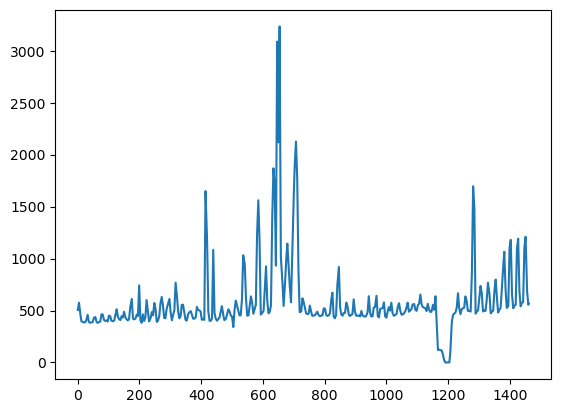

In [26]:
file_merge['dlh_all'].plot()

In [27]:
#负值判断
file_merge.mask(file_merge<0).isnull().any()

dlh_all      False
xlh_all      False
sy_all       False
xlh_under    False
dlh_under    False
MO           False
DY           False
HR           False
T            False
WS           False
WD           False
RH           False
P            False
dlh_water    False
xlh_water    False
sy_water     False
dlh_gas      False
xlh_gas      False
dtype: bool

#### 1.2.1.3 数据展示

In [28]:
file_merge
# 提取第七列（索引为6）和第1242行到第1461行（索引从1241到1460）
extracted_data_iloc = file_merge.iloc[1242:1462, 7:9]  # 注意，索引是从0开始

print(extracted_data_iloc)

      HR      T
1242   1  20.04
1243   2  20.05
1244   3  20.02
1245   4  19.93
1246   5  19.84
...   ..    ...
1457   0  24.46
1458   1  24.40
1459   2  24.26
1460   3  23.98
1461   4  23.68

[220 rows x 2 columns]


<Axes: >

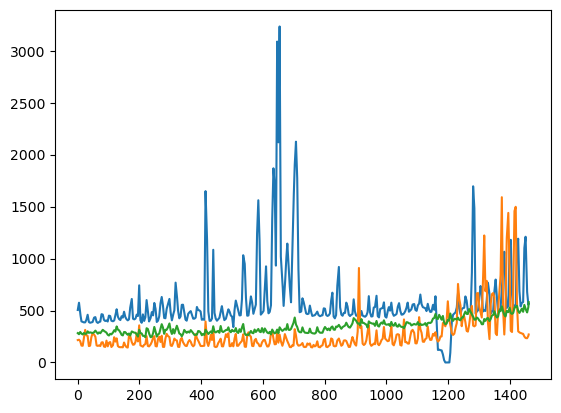

In [29]:
file_merge['dlh_all'].plot() #蓝
file_merge['xlh_all'].plot() #黄
file_merge['sy_all'].plot() #绿

<Axes: >

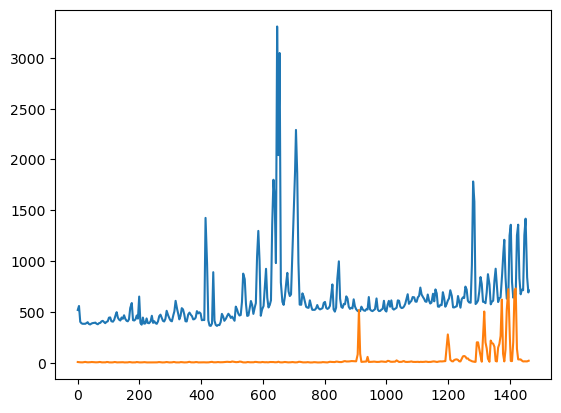

In [30]:
file_merge['dlh_under'].plot() #蓝
file_merge['xlh_under'].plot() #黄

<Axes: >

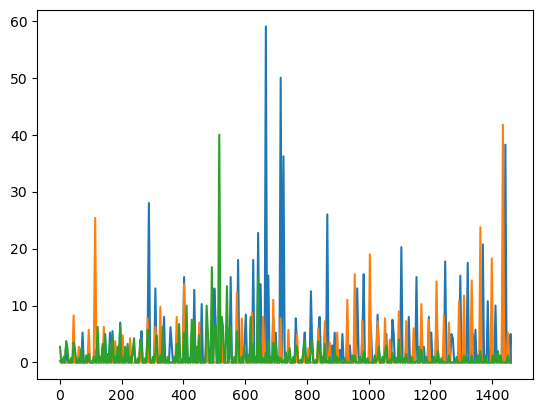

In [31]:
file_merge['dlh_water'].plot() #蓝
file_merge['xlh_water'].plot() #黄
file_merge['sy_water'].plot() #绿

<Axes: >

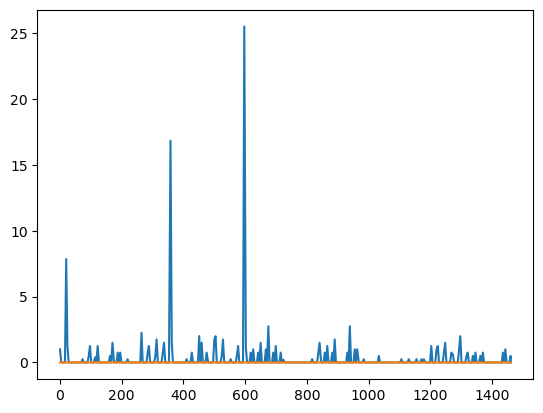

In [32]:
file_merge['dlh_gas'].plot() #蓝
file_merge['xlh_gas'].plot() #黄

## 2. **模型构建和训练** -- 电力and制冷

### 2.1 特征工程

In [33]:
#预测大莲花的制冷和电力负荷

In [35]:
# 特征数据集
X = file_merge
X = X.drop(columns=['xlh_gas'], axis=1)
X = X.drop(columns=['xlh_all'], axis=1)
X = X.drop(columns=['xlh_under'], axis=1)
X = X.drop(columns=['xlh_water'], axis=1)  #删去小莲花相关特征数据

y = file_merge[['dlh_all','dlh_under']]    #大莲花的制冷和电力负荷

In [36]:
X.max()

dlh_all      3233.5000
sy_all        580.7100
dlh_under    3309.0125
MO              5.0000
DY             31.0000
HR             23.0000
T              26.8000
WS             10.4300
WD            359.2700
RH            100.0000
P             100.9300
dlh_water      59.0000
sy_water       40.0000
dlh_gas        25.5000
dtype: float64

In [37]:
X.min()

dlh_all        0.00
sy_all       243.10
dlh_under    362.45
MO             3.00
DY             1.00
HR             0.00
T              3.75
WS             0.28
WD             0.00
RH            36.94
P             98.14
dlh_water      0.00
sy_water       0.00
dlh_gas        0.00
dtype: float64

In [38]:
X

,dlh_all,sy_all,dlh_under,MO,DY,HR,T,WS,WD,RH,P,dlh_water,sy_water,dlh_gas
0,505.00000,282.50000,518.960000,3,30,7,9.32,3.65,86.32,93.62,100.01,0.2500,2.7500,1.000
1,522.46875,279.81750,528.861875,3,30,8,9.38,4.52,91.68,89.19,100.01,0.1875,2.0625,0.750
2,539.93750,277.13500,538.763750,3,30,9,9.52,4.56,92.06,85.69,100.02,0.1250,1.3750,0.500
3,557.40625,274.45250,548.665625,3,30,10,9.68,4.49,89.40,82.81,99.99,0.0625,0.6875,0.250
4,574.87500,271.77000,558.567500,3,30,11,9.79,4.54,87.14,80.81,99.94,0.0000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,647.07500,494.51975,802.766250,5,30,0,24.46,1.28,1.05,94.75,99.14,1.2500,0.0000,0.125
1458,616.55000,507.44150,765.672500,5,30,1,24.40,0.85,24.92,94.62,99.08,2.5000,0.0000,0.250
1459,586.02500,520.36325,728.578750,5,30,2,24.26,0.73,52.39,95.44,99.04,3.7500,0.0000,0.375
1460,555.50000,533.28500,691.485000,5,30,3,23.98,0.60,86.28,95.69,99.06,5.0000,0.0000,0.500


In [39]:
#归一化 X
x=(X-X.min())/(X.max()-X.min())
x['MO']=X['MO']
x['DY']=X['DY']
x['HR']=X['HR']
x

,dlh_all,sy_all,dlh_under,MO,DY,HR,T,WS,WD,RH,P,dlh_water,sy_water,dlh_gas
0,0.156178,0.116703,0.053116,3,30,7,0.241649,0.332020,0.240265,0.898827,0.670251,0.004237,0.068750,0.039216
1,0.161580,0.108757,0.056477,3,30,8,0.244252,0.417734,0.255184,0.828576,0.670251,0.003178,0.051562,0.029412
2,0.166982,0.100812,0.059837,3,30,9,0.250325,0.421675,0.256242,0.773073,0.673835,0.002119,0.034375,0.019608
3,0.172385,0.092866,0.063198,3,30,10,0.257267,0.414778,0.248838,0.727402,0.663082,0.001059,0.017188,0.009804
4,0.177787,0.084920,0.066558,3,30,11,0.262039,0.419704,0.242547,0.695687,0.645161,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,0.200116,0.744705,0.149434,5,30,0,0.898482,0.098522,0.002923,0.916746,0.358423,0.021186,0.000000,0.004902
1458,0.190676,0.782979,0.136845,5,30,1,0.895879,0.056158,0.069363,0.914684,0.336918,0.042373,0.000000,0.009804
1459,0.181236,0.821253,0.124256,5,30,2,0.889805,0.044335,0.145823,0.927688,0.322581,0.063559,0.000000,0.014706
1460,0.171795,0.859527,0.111667,5,30,3,0.877657,0.031527,0.240154,0.931652,0.329749,0.084746,0.000000,0.019608


In [40]:
y

,dlh_all,dlh_under
0,505.00000,518.960000
1,522.46875,528.861875
2,539.93750,538.763750
3,557.40625,548.665625
4,574.87500,558.567500
...,...,...
1457,647.07500,802.766250
1458,616.55000,765.672500
1459,586.02500,728.578750
1460,555.50000,691.485000


In [41]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False, random_state=666)
#训练集和测试集划分

### 2.2 模型训练

In [42]:
# 模型搭建

#MLP模型：四个全连接层
model_MLP = Sequential([
    layers.Dense(14, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

#CNN模型：卷积层+汇聚层+三个全连接层
model_CNN = Sequential([
    layers.Conv1D(64,3, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

#RNN模型：RNN层+三个全连接层
model_RNN = Sequential([
    layers.SimpleRNN(64, input_shape=(24,14)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

In [43]:
#超参数
lr=0.0005 #学习率
epoch = 1500 #迭代数
model = model_CNN #模型选择(model_MLP, model_CNN, )

checkpoint_file = "best_model-dlh.hdf5" #权重保存命名

In [44]:
#训练集和测试集的数据格式转换-用于tensorflow引擎训练
def create_batch_dataset(X, y, train=True, buffer_size=2000, batch_size=64):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型
    if train: # 训练集
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else: # 测试集
        return batch_data.batch(batch_size)

In [45]:
if model == model_MLP:
  # 构造训练特征数据集
  train_dataset, train_labels = np.array(X_train), np.array(y_train)
  # 构造测试特征数据集
  test_dataset, test_labels = np.array(X_test), np.array(y_test)
  # 训练批数据
  train_batch_dataset = create_batch_dataset(train_dataset, train_labels)
  # 测试批数据
  test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)


In [46]:
if model == model_CNN:
  # 构造训练特征数据集
  train_dataset, train_labels = np.array(X_train), np.array(y_train)
  # 构造测试特征数据集
  test_dataset, test_labels = np.array(X_test), np.array(y_test)
  train_dataset=train_dataset.reshape((1242, 14,1))
  test_dataset=test_dataset.reshape((220, 14,1))#220属于0.85测试集情况下的特俗情况，非通用。
  # 训练批数据
  train_batch_dataset = create_batch_dataset(train_dataset, train_labels)
  # 测试批数据
  test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)


In [47]:
#时序数据集划分
def create_dataset(X, y, seq_len=10):
    features = []
    targets = []

    for i in range(0, len(X) - seq_len, 1):
        data = X.iloc[i:i+seq_len] # 序列数据
        label = y.iloc[i+seq_len] # 标签数据
        # 保存到features和labels
        features.append(data)
        targets.append(label)

    # 返回
    return np.array(features), np.array(targets)

In [48]:
if model == model_RNN:
  # 构造训练特征数据集
  train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=24)
  # 构造测试特征数据集
  test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=24)
  # 训练批数据
  train_batch_dataset = create_batch_dataset(train_dataset, train_labels)
  # 测试批数据
  test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

Epoch 1/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 526.8083 - val_loss: 2565.5107
Epoch 2/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 126.9370 - val_loss: 2907.2754
Epoch 3/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 106.1958 - val_loss: 3068.7983
Epoch 4/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 96.6231 - val_loss: 2904.0017
Epoch 5/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.3372 - val_loss: 3204.7073
Epoch 6/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94.5661 - val_loss: 3021.0000
Epoch 7/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 105.0019 - val_loss: 2967.8809
Epoch 8/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.4425 - val_loss: 2972.0193
Epoch 9/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.7821 - val_loss: 3007.5762
Epoch 10/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 99.4581 - val_loss: 3199.3755
Epoch 11/1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 108.7787 - val_loss: 2491.7573
E

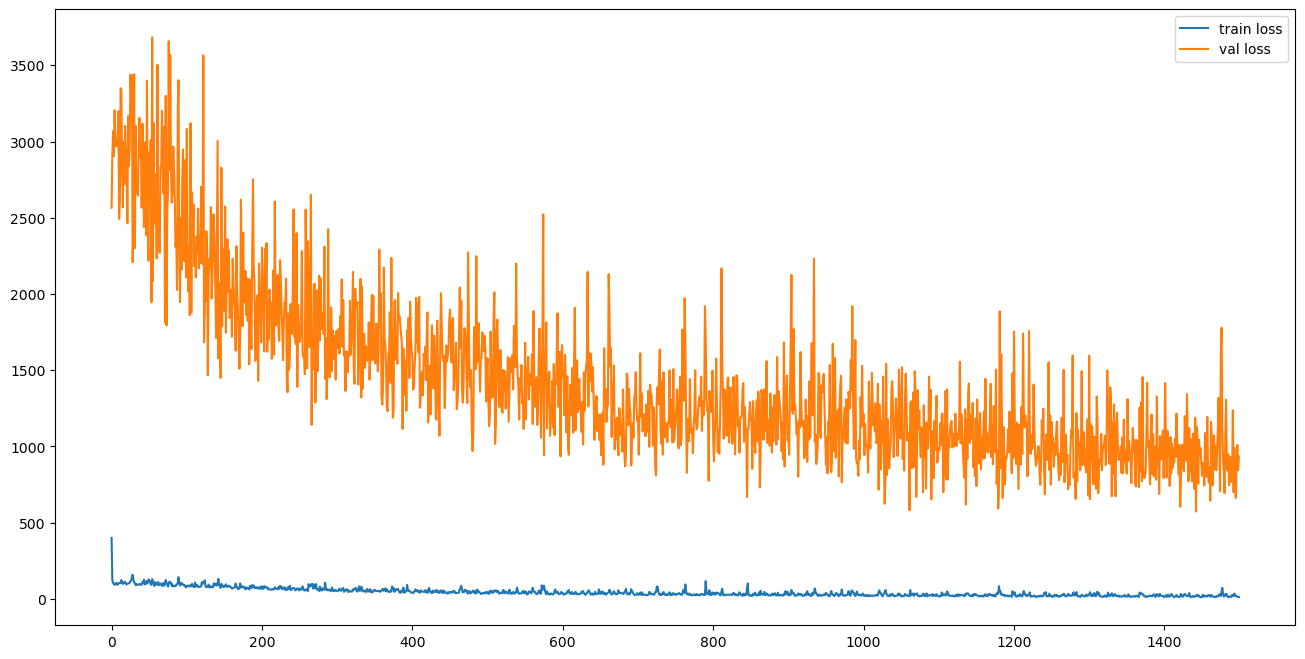

In [57]:
checkpoint_file = 'best_model-dlh.weights.h5'
op = tf.keras.optimizers.Adam(learning_rate=lr) #选择adam优化器
model.compile(optimizer='adam',loss='mse')  #模型编译
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file,

                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True) #模型保存
# 模型训练
history = model.fit(train_batch_dataset,
                    epochs=epoch,
                    validation_data=test_batch_dataset,
                    callbacks=[checkpoint_callback])
# 显示训练结果
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

## 3. **模型验证**

In [58]:
test_preds = model.predict(test_dataset, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [60]:
# 计算r2值
score = r2_score(test_labels, test_preds)
print("r^2 值为： ", score)


r^2 值为：  0.9856443827110436


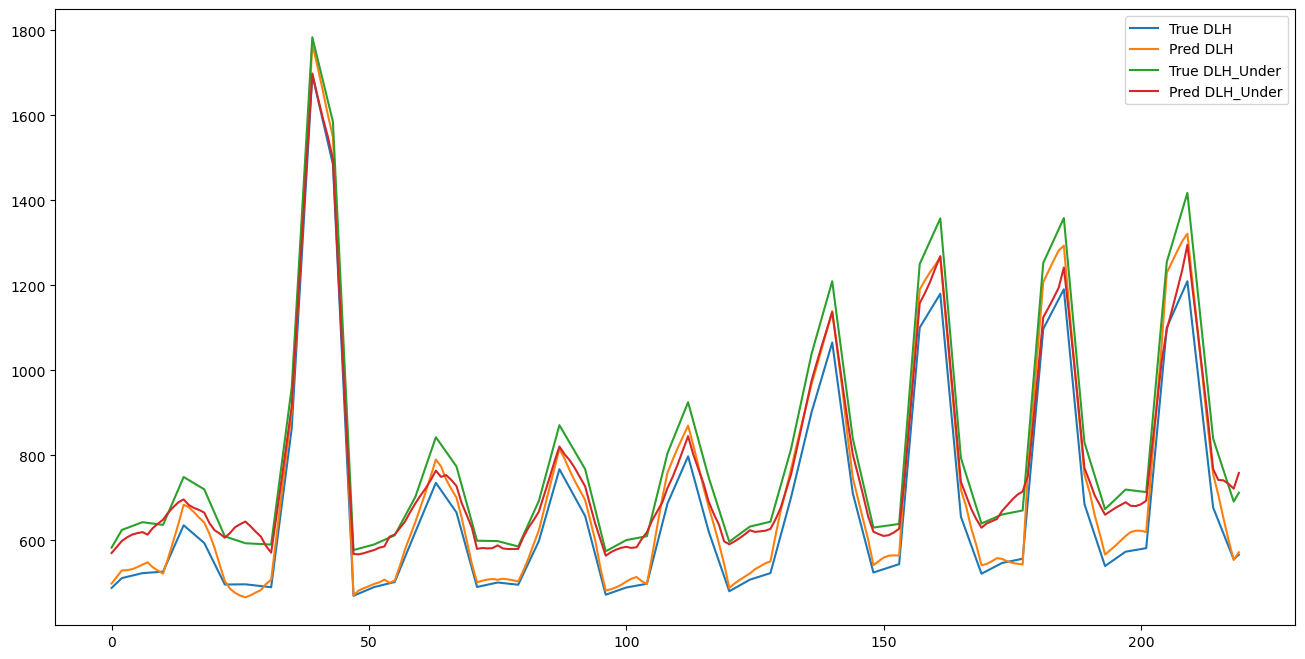

[[ 498.73907  570.5005 ]
 [ 514.1299   584.6363 ]
 [ 529.5933   598.8525 ]
 [ 530.0685   607.3452 ]
 [ 532.446    613.8084 ]
 [ 537.386    617.1887 ]
 [ 543.12463  619.67926]
 [ 548.5156   613.7773 ]
 [ 536.97455  629.141  ]
 [ 529.16675  639.44293]
 [ 522.1011   649.0006 ]
 [ 559.1256   665.6132 ]
 [ 598.81854  678.5177 ]
 [ 639.6735   689.9773 ]
 [ 684.17065  696.6307 ]
 [ 678.055    683.32086]
 [ 666.65497  676.60626]
 [ 653.83466  671.8006 ]
 [ 642.1351   665.56866]
 [ 615.899    640.9699 ]
 [ 582.97406  624.2094 ]
 [ 543.0377   616.27576]
 [ 504.48306  606.6007 ]
 [ 486.73993  617.4518 ]
 [ 476.66986  631.369  ]
 [ 470.29712  638.4881 ]
 [ 466.3661   644.44556]
 [ 471.03152  633.25903]
 [ 477.4718   620.5192 ]
 [ 483.28485  609.2051 ]
 [ 497.5162   587.17456]
 [ 507.53845  571.313  ]
 [ 607.66016  654.9648 ]
 [ 707.0635   740.83344]
 [ 805.04266  828.69305]
 [ 903.6125   915.9396 ]
 [1117.3118  1115.5891 ]
 [1331.8246  1314.0757 ]
 [1546.2777  1512.7189 ]
 [1768.3221  1698.4744 ]


In [54]:
#绘制预测与真值结果
plt.figure(figsize=(16,8))
plt.plot(test_labels[:,0], label="True DLH") #真实大莲花电力负荷
plt.plot(test_preds[:,0], label="Pred DLH") #预测大莲花电力负荷
plt.plot(test_labels[:,1], label="True DLH_Under") #真实大莲花制冷负荷
plt.plot(test_preds[:,1], label="Pred DLH_Under") #预测大莲花制冷负荷
plt.legend(loc='best')
plt.show()
print(test_preds)
#创建数据框
df_time = pd.DataFrame(extracted_data_iloc)
df_loads = pd.DataFrame(test_preds, columns=['电力负荷', '热力负荷'])
df_loads.index = range(1242, 1462)

# 确保两个 DataFrame 的行数一致
assert len(df_time) == len(df_loads), "两个 DataFrame 的行数不一致，无法合并"

# 合并两个 DataFrame
df_combined = pd.concat([df_time, df_loads], axis=1)
print(df_combined)

# 逐行遍历表格内容，并对数据进行计算
for index, row in df_combined.iterrows():
    序号 = row[0]
    时间 = row['HR']  # 确保这里使用的数据框中的实际列名
    环境温度 = row['T']  # 确保这里使用的数据框中的实际列名
    电力负荷 = row['电力负荷']
    热力负荷 = row['热力负荷']  # 确保这里使用的数据框中的实际列名

    # 输出每一行的数据
    print(f"序号: {序号}, 时间: {时间}, 环境温度: {环境温度:.2f}, 电力负荷: {电力负荷:.2f}, 热力负荷: {热力负荷:.2f}")

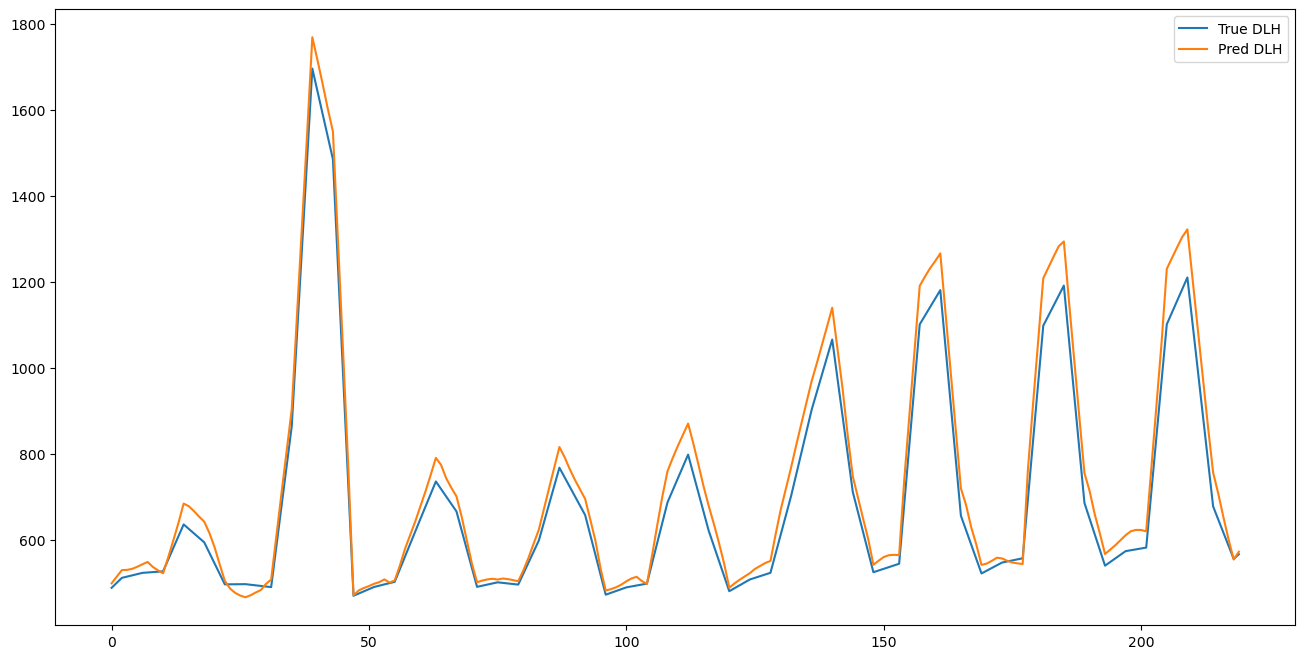

In [55]:
# 绘制 预测与真值结果

plt.figure(figsize=(16,8))
plt.plot(test_labels[:,0], label="True DLH") #真实大莲花电力负荷
plt.plot(test_preds[:,0], label="Pred DLH")  #预测大莲花电力负荷
plt.legend(loc='best')
plt.show()

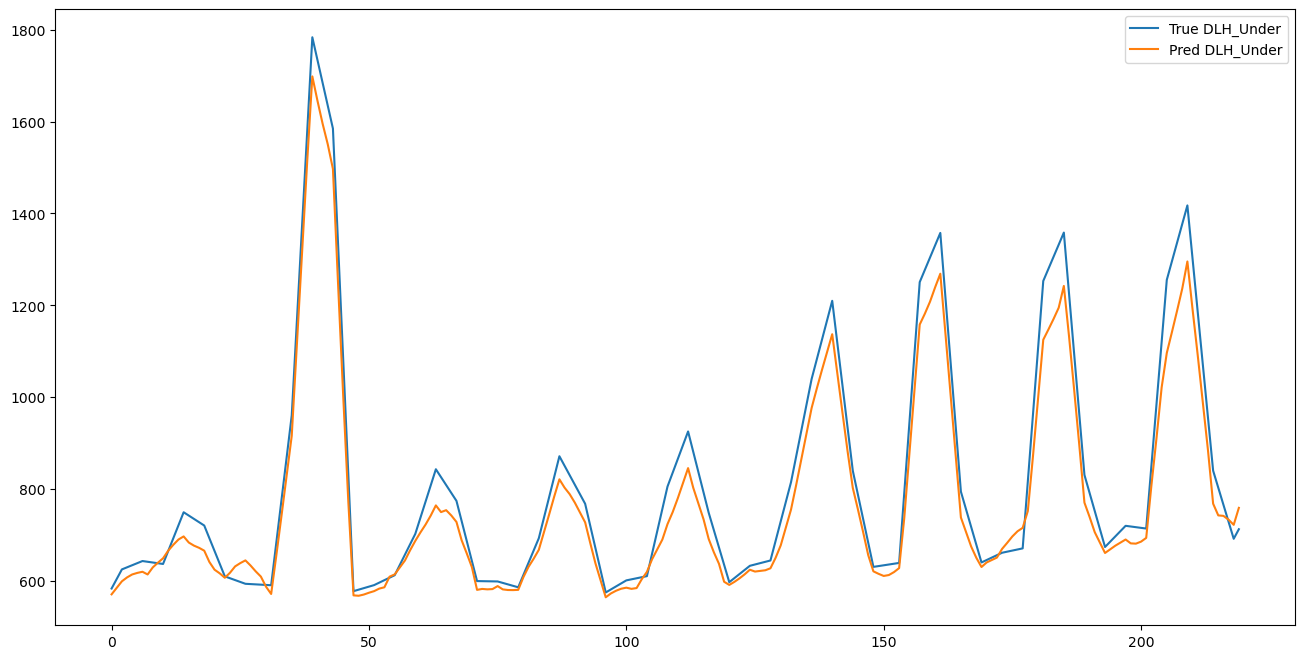

In [56]:
# 绘制 预测与真值结果
plt.figure(figsize=(16,8))
plt.plot(test_labels[:,1], label="True DLH_Under")  #真实大莲花制冷负荷
plt.plot(test_preds[:,1], label="Pred DLH_Under")   #预测大莲花制冷负荷
plt.legend(loc='best')
plt.show()